# Identificación Espectral

Se plantea la identificación de un sistema LTI utilizando las técnicas de periodograma y correlograma ante perturbaciones en la salida (ruido de medición)

In [1]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as signal
import math
from tqdm import tqdm

## Periodograma

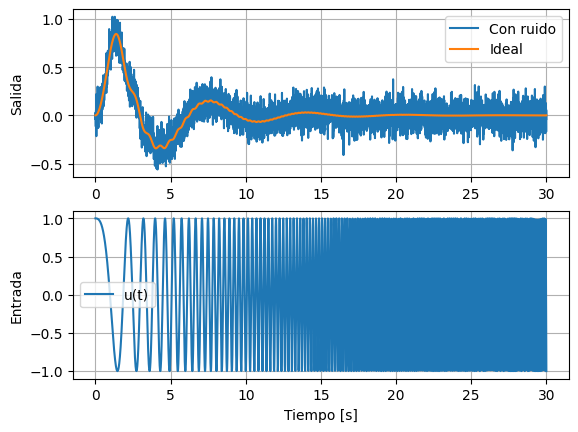

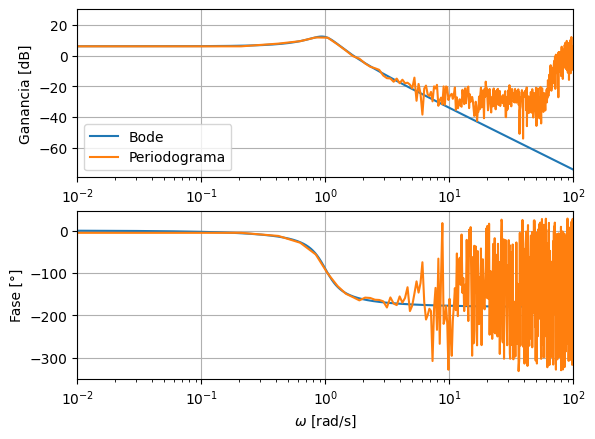

In [8]:
# Armo una función para llamarla con distintas entradas
def identicar_periodograma(t,u,v,window=False,plot=True):
    # Respuesta en Frecuencia de un Motor de CC
    s=ctrl.TransferFunction.s

    # Modelo de la Planta
    G= 2/(s**2+0.5*s+1)

    N = len(t)
    w_min = 0.01
    w_max = 100

    # Bode Exacto 
    mag,phase,w_calc = ctrl.bode_plot(G,plot=False,omega_limits=[w_min,w_max])
    # parámetros
    Ts = t[1]-t[0] 

    _,y = ctrl.forced_response(G, U=u, T=t)+v

    if plot:
        plt.figure()
        plt.subplot(211)
        plt.plot(t,y,label='Con ruido')
        plt.plot(t,y-v,label='Ideal')
        plt.grid(); plt.legend()
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Salida')
        plt.subplot(212)
        plt.plot(t,u,label='u(t)')
        plt.grid(); plt.legend()
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Entrada')    
        plt.show()

    # Estimación del espectro por periodograma
    win = np.ones_like(y)
    if window:
        win = signal.windows.hann(len(y))   # Hann, pero puede ser hamming, blackman, etc.

    Y = np.fft.fft(y*win)
    U = np.fft.fft(u*win)
    w = np.fft.fftfreq(N, Ts)*2*np.pi 

    G_per = Y/U

    mag_ident= np.abs(G_per[0:N//2])
    phase_ident = np.angle(G_per[0:N//2])
    phase_ident = np.where(phase_ident > 0.5, phase_ident - 2*np.pi, phase_ident)
    phase_ident *= 180/np.pi
    w_ident = w[0:N//2]

    if plot:
        plt.figure()
        plt.subplot(211)
        plt.semilogx(w_calc,20*np.log10(mag),label='Bode')
        plt.semilogx(w_ident,20*np.log10(mag_ident),label='Periodograma')
        plt.xlim(w_min,w_max)
        plt.ylabel('Ganancia [dB]')
        plt.legend()
        plt.grid()
        plt.subplot(212)
        plt.semilogx(w_calc,phase*180/np.pi,label='Bode')
        plt.semilogx(w_ident,phase_ident,label='Periodograma')
        plt.xlim(w_min,w_max)
        plt.ylabel('Fase [°]')
        plt.xlabel('$\omega$ [rad/s]')
        #plt.legend()
        plt.grid()

    return mag_ident,phase_ident,w_ident, mag, phase, w_calc

# Ensayo 1: Señal Chirp
# Cantidad de samples: Podemos ver que llega un punto que no ganamos mucho aumentando las muestras
N = 5000
# Vector de tiempos
t = np.linspace(0, 30, N) 
# Señal de excitación
u_chirp = signal.chirp(t, f0=0.1, f1=10, t1=t[-1], method='linear')
# Perturbación
# Variando el desvío vemos cómo el aumento de SNR mejora la estimación 
v0 = 0.1
v = v0*np.random.randn(N)
_ = identicar_periodograma(t,u_chirp,v)


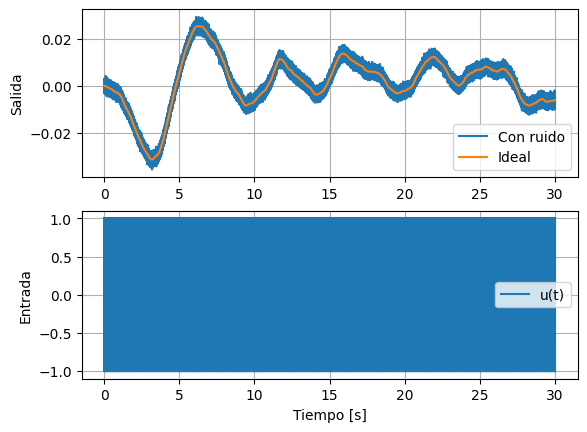

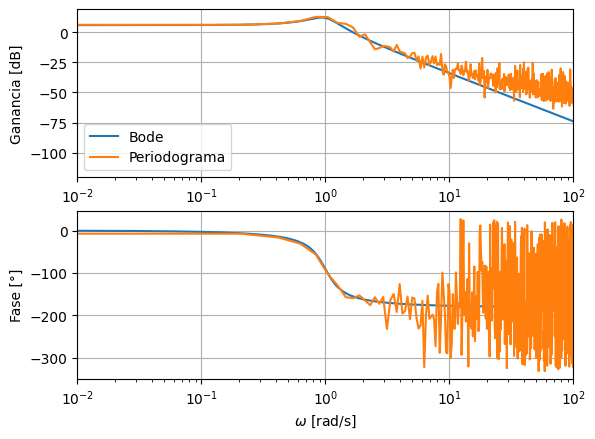

In [9]:
# Ensayo 2: Señal Estocástica
# Cantidad de samples: Podemos ver que el sesgo se corrige a medida que aumentamos N
N = 1000000
# Vector de tiempos
t = np.linspace(0, 30, N) 
# Señal de excitación
u_rand = np.sign(np.random.randn(N))
# Perturbación
# Variando el desvío vemos cómo el aumento de SNR mejora la estimación 
v0 = 0.001
v = v0*np.random.randn(N)
_ = identicar_periodograma(t,u_rand,v,window=False)

Procesando:   0%|          | 0/30 [00:00<?, ?it/s]

Procesando: 100%|██████████| 30/30 [03:39<00:00,  7.33s/it]


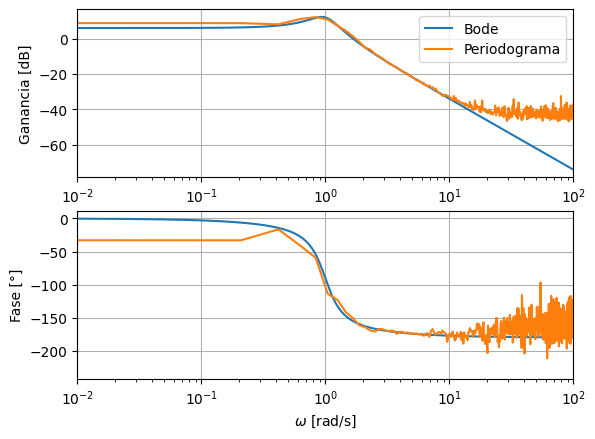

In [23]:

# Ensayo 3: Señal Estocástica, promediando varios experimentos
# Cantidad de samples: Podemos ver que el sesgo se corrige a medida que aumentamos N
N = 1000000
# Vector de tiempos
t = np.linspace(0, 30, N) 

N_ensayos = 30
m_acum = np.zeros(N//2)
p_acum = np.zeros(N//2)
for idx_ensayo in tqdm(range(N_ensayos), desc="Procesando"):
    # Señal de excitación
    u_rand = np.sign(np.random.randn(N))
    # Perturbación
    # Variando el desvío vemos cómo el aumento de SNR mejora la estimación 
    v0 = 0.005
    v = v0*np.random.randn(N)
    m,p,w,mc,pc,wc = identicar_periodograma(t,u_rand,v,plot=False,window=True)
    m_acum += m
    p_acum += p

plt.figure()
plt.subplot(211)
plt.semilogx(wc,20*np.log10(mc),label='Bode')
plt.semilogx(w,20*np.log10(m_acum/N_ensayos),label='Periodograma')
plt.xlim(wc[0],wc[-1])
plt.ylabel('Ganancia [dB]')
plt.legend()
plt.grid()
plt.subplot(212)
plt.semilogx(wc,pc*180/np.pi,label='Bode')
plt.semilogx(w,p_acum/N_ensayos,label='Periodograma')
plt.xlim(wc[0],wc[-1])
plt.ylabel('Fase [°]')
plt.xlabel('$\omega$ [rad/s]')
#plt.legend()
plt.grid()

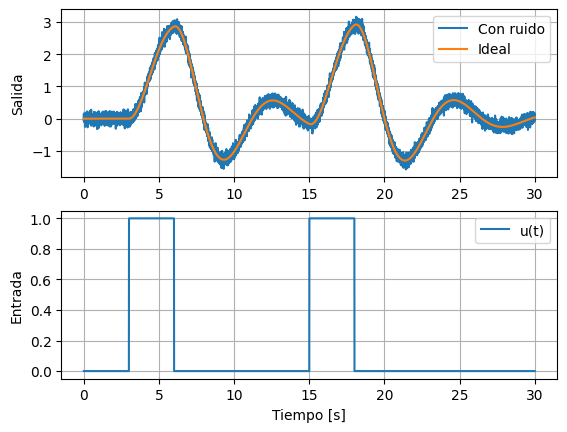

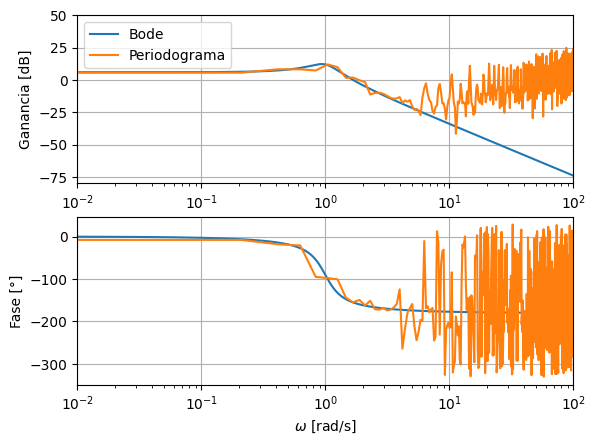

In [33]:
# Ensayo 4: Señal Escalón
# Cantidad de samples: Podemos ver que el sesgo se corrige a medida que aumentamos N
N = 10000
# Vector de tiempos
t = np.linspace(0, 30, N) 
# Señal de excitación
u_rand = np.zeros_like(t)
u_rand[1000:2000] = 1
u_rand[5000:6000] = 1
# Perturbación
# Variando el desvío vemos cómo el aumento de SNR mejora la estimación 
v0 = 0.1
v = v0*np.random.randn(N)
_ = identicar_periodograma(t,u_rand,v,window=True)

## Correlograma

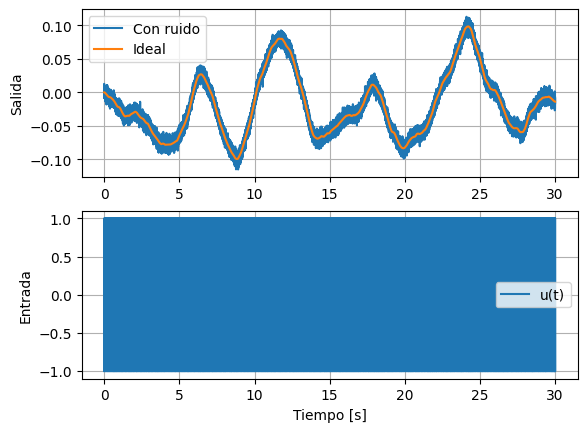

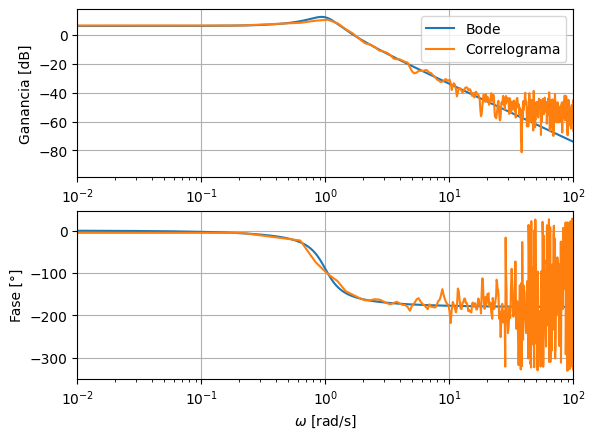

In [5]:
from scipy.signal import csd, welch

# Armo una función para llamarla con distintas entradas
def identicar_correlograma(t,u,v,window=False,plot=True):
    # Respuesta en Frecuencia de un Motor de CC
    s=ctrl.TransferFunction.s

    # Modelo de la Planta
    G= 2/(s**2+0.5*s+1)

    N = len(t)
    w_min = 0.01
    w_max = 100

    # Bode Exacto 
    mag,phase,w_calc = ctrl.bode_plot(G,plot=False,omega_limits=[w_min,w_max])
    # parámetros
    Ts = t[1]-t[0] 

    _,y = ctrl.forced_response(G, U=u, T=t)+v

    if plot:
        plt.figure()
        plt.subplot(211)
        plt.plot(t,y,label='Con ruido')
        plt.plot(t,y-v,label='Ideal')
        plt.grid(); plt.legend()
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Salida')
        plt.subplot(212)
        plt.plot(t,u,label='u(t)')
        plt.grid(); plt.legend()
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Entrada')    
        plt.show()

    # Estimación del espectro por periodograma
    win = np.ones_like(y)
    if window:
        win = signal.windows.hann(len(y))   # Hann, pero puede ser hamming, blackman, etc.

    ruy = np.correlate(y,u,'same')
    ruu = np.correlate(u,u,'same')
    
    Puy = np.fft.fft(ruy*win)
    Puu = np.fft.fft(ruu*win)
    w = np.fft.fftfreq(N, Ts)*2*np.pi 
    G_corr = Puy/Puu

    # Estimación de la función de transferencia (empírica)
    G_corr = Puy / Puu

    mag_ident= np.abs(G_corr[0:N//2])
    phase_ident = np.angle(G_corr[0:N//2])
    phase_ident = np.where(phase_ident > 0.5, phase_ident - 2*np.pi, phase_ident)
    phase_ident *= 180/np.pi
    w_ident = w[0:N//2]

    if plot:
        plt.figure()
        plt.subplot(211)
        plt.semilogx(w_calc,20*np.log10(mag),label='Bode')
        plt.semilogx(w_ident,20*np.log10(mag_ident),label='Correlograma')
        plt.xlim(w_min,w_max)
        plt.ylabel('Ganancia [dB]')
        plt.legend()
        plt.grid()
        plt.subplot(212)
        plt.semilogx(w_calc,phase*180/np.pi,label='Bode')
        plt.semilogx(w_ident,phase_ident,label='Correlograma')
        plt.xlim(w_min,w_max)
        plt.ylabel('Fase [°]')
        plt.xlabel('$\omega$ [rad/s]')
        #plt.legend()
        plt.grid()

    return mag_ident,phase_ident,w_ident, mag, phase, w_calc

# Ensayo 1: Señal estocástica
# Cantidad de samples: Podemos ver que llega un punto que no ganamos mucho aumentando las muestras
N = 50000
# Vector de tiempos
t = np.linspace(0, 30, N) 
# Señal de excitación
u = np.sign(np.random.randn(N))
# Perturbación
# Variando el desvío vemos cómo el aumento de SNR mejora la estimación 
v0 = 0.005
v = v0*np.random.randn(N)
_ = identicar_correlograma(t,u,v,window=True)


Procesando: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


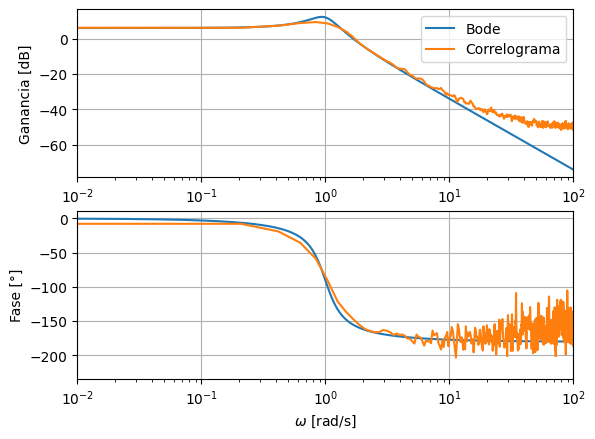

In [6]:

# Ensayo 2: Señal Estocástica, promediando varios experimentos
# Cantidad de samples: Podemos ver que el sesgo se corrige a medida que aumentamos N
N = 50000
# Vector de tiempos
t = np.linspace(0, 30, N) 

N_ensayos = 30
m_acum = np.zeros(N//2)
p_acum = np.zeros(N//2)
for idx_ensayo in tqdm(range(N_ensayos), desc="Procesando"):
    # Señal de excitación
    u_rand = np.sign(np.random.randn(N))
    # Perturbación
    # Variando el desvío vemos cómo el aumento de SNR mejora la estimación 
    v0 = 0.005
    v = v0*np.random.randn(N)
    m,p,w,mc,pc,wc = identicar_correlograma(t,u_rand,v,plot=False,window=True)
    m_acum += m
    p_acum += p

plt.figure()
plt.subplot(211)
plt.semilogx(wc,20*np.log10(mc),label='Bode')
plt.semilogx(w,20*np.log10(m_acum/N_ensayos),label='Correlograma')
plt.xlim(wc[0],wc[-1])
plt.ylabel('Ganancia [dB]')
plt.legend()
plt.grid()
plt.subplot(212)
plt.semilogx(wc,pc*180/np.pi,label='Bode')
plt.semilogx(w,p_acum/N_ensayos,label='Correlograma')
plt.xlim(wc[0],wc[-1])
plt.ylabel('Fase [°]')
plt.xlabel('$\omega$ [rad/s]')
#plt.legend()
plt.grid()